# 🎵 Clasificación de Emociones con Redes Neuronales Cuánticas

**Dataset:** CREMA-D (Audio Emotion Recognition)

## 📋 Características del Notebook

- **Modelos híbridos clásico-cuánticos** con PennyLane
- **Transfer learning** con ResNet18/VGG16 pre-entrenados
- **Redes convolucionales entrenables** desde cero
- **Visualización avanzada** de resultados y circuitos cuánticos
- **Comparación cuántico vs clásico** con métricas detalladas
- **Análisis de circuitos cuánticos** con diagramas
- **Configuración flexible** de hiperparámetros

## 🔬 Fundamentos Teóricos

### Redes Neuronales Cuánticas (QNNs)

Las QNNs combinan computación cuántica con aprendizaje automático. En este notebook implementamos un **circuito cuántico variacional** que actúa como capa de clasificación:

$$\hat{y} = f_{\theta}(U(\phi(x))|0\rangle)$$

Donde:
- $x$ son las características extraídas por la red clásica
- $U(\phi(x))$ es el circuito cuántico con embedding de características
- $f_{\theta}$ es la función de medición
- $\hat{y}$ es la predicción final

### Arquitectura Híbrida

```
Input → CNN (ResNet18/VGG16) → Feature Extraction → Quantum Circuit → Classification
```

Basado en el trabajo de Mari et al. (2020) y Pablo Conte


In [38]:
# Configuración inicial
import sys 
sys.path.append('src')

%load_ext autoreload
%autoreload 2

# Configuración de entorno
%env OMP_NUM_THREADS=1
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: OMP_NUM_THREADS=1


In [39]:
# Importaciones principales
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import transforms, datasets
from torchvision.models import ResNet18_Weights, VGG16_Weights
import pennylane as qml
import time
import os
from collections import Counter
from torch.utils.data import DataLoader

# Módulos personalizados
from dataset import get_dataloaders, create_dataloaders, count_images_per_class_from_dataset
from quantum_circuit import Quantumnet, DressedQuantumCircuit, build_qnode, build_qnode2
from training import train_model1, save_model, load_model, visualize_model
from utils import imshow, show_exact_images_from_dataloader

print("✅ Todas las importaciones completadas")


✅ Todas las importaciones completadas


## 🔧 Configuración de Hiperparámetros


In [40]:
# Configuración del modelo
base_model = 'resnet18'  # 'resnet18', 'vgg16', o 'custom_cnn'
n_qubits = 4             # Número de qubits
quantum = True           # True para modelo cuántico, False para clásico
classical_model = '512_nq_2'  # Opciones: '512_2', '512_nq_2', '551_512_2'

# NUEVA OPCIÓN: Red convolucional entrenable desde cero
use_pretrained = True    # True: usar modelo pre-entrenado, False: entrenar desde cero
freeze_backbone = True   # True: congelar backbone, False: entrenar todo
use_generic_weights = False  # True: usar pesos genéricos en capa de conexión

# Parámetros de entrenamiento
step = 0.0004 if quantum else 0.0009  # Learning rate
batch_size = 8                        # Tamaño del batch
num_epochs = 25                       # Número de épocas
q_depth = 4                           # Profundidad del circuito cuántico
gamma_lr_scheduler = 0.1              # Reducción del learning rate
max_layers = 15                       # Capas máximas (mantener en 15)
q_delta = 0.01                        # Dispersión inicial de pesos cuánticos
rng_seed = 42                         # Semilla para reproducibilidad

# Configuración de datos
data_dir = '../CremaD/mel_spec_reduced_HAP_SAD'
spec_augment = True                   # Aplicar SpecAugment
grayscale = True                     # Usar imágenes en escala de grises

print(f"🎯 Configuración: {base_model} + {'Cuántico' if quantum else 'Clásico'}")
print(f"📊 Qubits: {n_qubits}, Profundidad: {q_depth}, Batch: {batch_size}")
print(f"🔧 Pre-entrenado: {use_pretrained}, Congelado: {freeze_backbone}")
print(f"🎲 Pesos genéricos: {use_generic_weights}")


🎯 Configuración: resnet18 + Cuántico
📊 Qubits: 4, Profundidad: 4, Batch: 8
🔧 Pre-entrenado: True, Congelado: True
🎲 Pesos genéricos: False


In [41]:
# Dispositivo cuántico (PennyLane)
dev = qml.device('default.qubit', wires=n_qubits)

# Dispositivo clásico (GPU/CPU)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"✅ Dispositivo cuántico: {dev}")
print(f"✅ Dispositivo clásico: {device}")

if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
    print(f"💾 Memoria GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

# Configurar semilla para reproducibilidad
torch.manual_seed(rng_seed)
np.random.seed(rng_seed)


✅ Dispositivo cuántico: <default.qubit device (wires=4) at 0x2691961ead0>
✅ Dispositivo clásico: cuda:0
🚀 GPU: NVIDIA GeForce RTX 4070 Laptop GPU
💾 Memoria GPU: 8.6 GB


## 📊 Carga y Análisis de Datos

### Función de Carga de Datos Mejorada

Implementamos una función que permite cargar datos tanto en color como en escala de grises, con análisis detallado de la distribución de clases.


In [42]:
# Función mejorada para crear dataloaders
def create_dataloaders_enhanced(data_dir, batch_size=8, shuffle=True, num_workers=4, grayscale=False, force_three_channels=False):
    """
    Crea dataloaders con análisis detallado de clases.
    
    Args:
        data_dir: Directorio con subcarpetas 'train' y 'val'
        batch_size: Tamaño del batch
        shuffle: Mezclar datos de entrenamiento
        num_workers: Número de workers para DataLoader
        grayscale: Convertir a escala de grises
        force_three_channels: Si True, duplica canal gris a 3 canales
    
    Returns:
        dataloaders, dataset_sizes, class_names, counts_per_class
    """
    # Estadísticas de normalización
    if grayscale and not force_three_channels:
        mean, std = [0.5], [0.5]
    else:
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]

    # Pipeline de transformaciones
    transform_list = [transforms.Resize((224, 224))]
    if grayscale:
        # Si usamos backbones preentrenados, repetimos el canal a 3
        if force_three_channels:
            transform_list.append(transforms.Grayscale(num_output_channels=3))
        else:
            transform_list.append(transforms.Grayscale(num_output_channels=1))
    transform_list += [
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]
    data_transform = transforms.Compose(transform_list)

    # Crear datasets
    image_datasets = {
        phase: datasets.ImageFolder(os.path.join(data_dir, phase), transform=data_transform)
        for phase in ['train', 'val']
    }

    # Crear dataloaders
    dataloaders = {
        phase: DataLoader(
            image_datasets[phase],
            batch_size=batch_size,
            shuffle=(shuffle if phase == 'train' else False),
            num_workers=num_workers
        )
        for phase in ['train', 'val']
    }

    # Información del dataset
    dataset_sizes = {phase: len(image_datasets[phase]) for phase in ['train', 'val']}
    class_names = image_datasets['train'].classes

    # Conteo por clase
    counts_per_class = {
        phase: count_images_per_class_from_dataset(image_datasets[phase], class_names)
        for phase in ['train', 'val']
    }

    return dataloaders, dataset_sizes, class_names, counts_per_class

print("✅ Función de carga de datos definida")


✅ Función de carga de datos definida


In [43]:
# Cargar datos
print(f"📁 Cargando datos desde: {data_dir}")

# Forzar 3 canales si usamos backbones preentrenados (esperan RGB con normalización ImageNet)
force_three_channels = grayscale and use_pretrained

dataloaders, dataset_sizes, class_names, counts_per_class = create_dataloaders_enhanced(
    data_dir=data_dir,
    batch_size=batch_size,
    shuffle=True,
    grayscale=grayscale,
    force_three_channels=force_three_channels
)

n_classes = len(class_names)

print(f"✅ Datos cargados exitosamente")
print(f"📊 Clases: {class_names}")
print(f"📈 Tamaños: Train={dataset_sizes['train']}, Val={dataset_sizes['val']}")

# Análisis detallado de distribución de clases
print(f"\n📊 Análisis de distribución de clases:")
print("=" * 60)

for phase in ['train', 'val']:
    print(f"\n{phase.upper()}:")
    counts = counts_per_class[phase]
    total = sum(counts.values())
    
    for class_name, count in counts.items():
        percentage = (count / total) * 100
        print(f"  {class_name}: {count} muestras ({percentage:.1f}%)")
    print(f"  Total: {total} muestras")


📁 Cargando datos desde: ../CremaD/mel_spec_reduced_HAP_SAD
✅ Datos cargados exitosamente
📊 Clases: ['Happy', 'Sad']
📈 Tamaños: Train=897, Val=497

📊 Análisis de distribución de clases:

TRAIN:
  Happy: 448 muestras (49.9%)
  Sad: 449 muestras (50.1%)
  Total: 897 muestras

VAL:
  Happy: 249 muestras (50.1%)
  Sad: 248 muestras (49.9%)
  Total: 497 muestras


🖼️ Visualizando muestras del dataset:


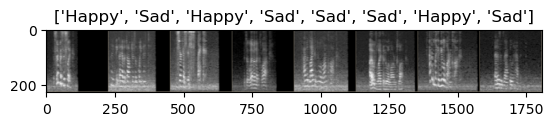

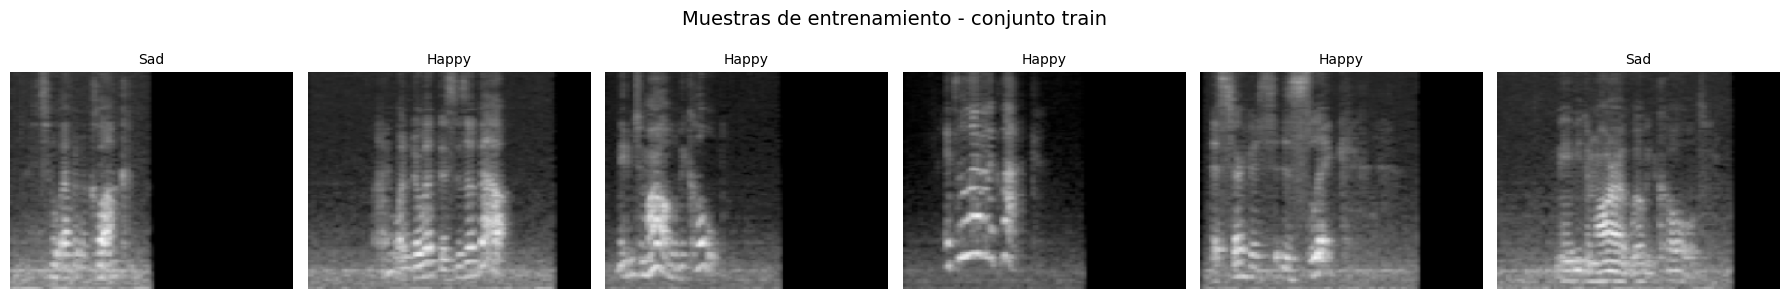

In [44]:
# Visualización de muestras del dataset
print("🖼️ Visualizando muestras del dataset:")

# Obtener un batch de entrenamiento
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

# Mostrar imágenes individuales
show_exact_images_from_dataloader(
    dataloaders['train'], 
    phase='train', 
    n_images=6, 
    prefix='Muestras de entrenamiento',
    grayscale=grayscale
)


## 🧠 Construcción del Modelo

### Arquitecturas Disponibles

1. **Transfer Learning**: Modelos pre-entrenados (ResNet18/VGG16) con capas congeladas
2. **Entrenamiento desde cero**: Redes convolucionales completamente entrenables
3. **Híbrido**: Backbone congelado + capa de clasificación entrenable

### Circuito Cuántico

El circuito cuántico implementa un **ansatz variacional** con:

- **Feature Map**: Embedding de características clásicas en estados cuánticos
- **Layers Variacionales**: Rotaciones parametrizadas y entrelazamiento
- **Medición**: Observables de Pauli-Z para extraer información cuántica

$$\mathcal{L} = \sum_{i=1}^{N} \mathcal{L}_{CE}(f_{\theta}(U(\phi(x_i))|0\rangle), y_i)$$


In [45]:
# Función para crear red convolucional personalizada
def create_custom_cnn(n_classes, input_channels=3):
    """
    Crea una red convolucional personalizada para entrenar desde cero.
    
    Args:
        n_classes: Número de clases de salida
        input_channels: Número de canales de entrada (3 para RGB, 1 para grayscale)
    
    Returns:
        Modelo CNN personalizado
    """
    class CustomCNN(nn.Module):
        def __init__(self, n_classes, input_channels=3):
            super(CustomCNN, self).__init__()
            
            # Capas convolucionales
            self.features = nn.Sequential(
                # Bloque 1
                nn.Conv2d(input_channels, 64, kernel_size=7, stride=2, padding=3),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
                
                # Bloque 2
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # Bloque 3
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                
                # Bloque 4
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(inplace=True),
                nn.AdaptiveAvgPool2d((1, 1))
            )
            
            # Capa de clasificación
            self.classifier = nn.Linear(512, n_classes)
            
        def forward(self, x):
            x = self.features(x)
            x = torch.flatten(x, 1)
            x = self.classifier(x)
            return x
    
    return CustomCNN(n_classes, input_channels)

print("✅ Función para CNN personalizada definida")


✅ Función para CNN personalizada definida


In [46]:
# Construir modelo según configuración
print(f"🏗️ Construyendo modelo {base_model}...")

if base_model == 'custom_cnn':
    # Red convolucional personalizada
    model_hybrid = create_custom_cnn(n_classes, input_channels=1 if grayscale and not use_pretrained else 3)
    print(f"✅ CNN personalizada creada (entrenamiento desde cero)")
    
elif base_model == 'resnet18':
    # ResNet18
    if use_pretrained:
        model_hybrid = torchvision.models.resnet18(weights=ResNet18_Weights.DEFAULT)
        print(f"✅ ResNet18 pre-entrenado cargado")
    else:
        model_hybrid = torchvision.models.resnet18(weights=None)
        print(f"✅ ResNet18 sin pre-entrenar (entrenamiento desde cero)")
    
    # Si trabajamos en escala de grises y no forzamos 3 canales en los datos, adaptar primera capa
    if grayscale and not ('force_three_channels' in globals() and force_three_channels):
        model_hybrid.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        print("🎛️ ResNet18 adaptado para 1 canal de entrada")
    
    # Configurar congelamiento
    if freeze_backbone:
        for param in model_hybrid.parameters():
            param.requires_grad = False
        print(f"🔒 Backbone congelado")
    else:
        print(f"🔥 Backbone entrenable")
    
    # Reemplazar capa final
    if quantum:
        model_hybrid.fc = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes
        )
        print(f"✅ Capa cuántica: {n_qubits} qubits, profundidad {q_depth}")
    else:
        if classical_model == '512_2':
            model_hybrid.fc = nn.Linear(512, n_classes)
        elif classical_model == '512_nq_2':
            model_hybrid.fc = nn.Sequential(
                nn.Linear(512, n_qubits), 
                nn.ReLU(), 
                nn.Linear(n_qubits, n_qubits), 
                nn.ReLU(),
                nn.Linear(n_qubits, n_classes)
            )
        elif classical_model == '551_512_2':
            model_hybrid.fc = nn.Sequential(
                nn.Linear(512, 512), 
                nn.ReLU(), 
                nn.Linear(512, n_classes)
            )
        print(f"✅ Capa clásica: {classical_model}")

elif base_model == 'vgg16':
    # VGG16
    if use_pretrained:
        model_hybrid = torchvision.models.vgg16(weights=VGG16_Weights.DEFAULT)
        print(f"✅ VGG16 pre-entrenado cargado")
    else:
        model_hybrid = torchvision.models.vgg16(weights=None)
        print(f"✅ VGG16 sin pre-entrenar (entrenamiento desde cero)")

    # Si trabajamos en escala de grises y no forzamos 3 canales en los datos, adaptar primera capa
    if grayscale and not ('force_three_channels' in globals() and force_three_channels):
        first_layer = model_hybrid.features[0]
        if isinstance(first_layer, nn.Conv2d) and first_layer.in_channels == 3:
            model_hybrid.features[0] = nn.Conv2d(1, first_layer.out_channels, kernel_size=first_layer.kernel_size,
                                                  stride=first_layer.stride, padding=first_layer.padding, bias=False)
            print("🎛️ VGG16 adaptado para 1 canal de entrada")
    
    # Configurar congelamiento
    if freeze_backbone:
        for param in model_hybrid.parameters():
            param.requires_grad = False
        print(f"🔒 Backbone congelado")
    else:
        print(f"🔥 Backbone entrenable")
    
    # Reemplazar capa final
    if quantum:
        model_hybrid.classifier[6] = Quantumnet(
            n_qubits=n_qubits,
            q_depth=q_depth,
            max_layers=max_layers,
            q_delta=q_delta,
            dev=dev, 
            n_classes=n_classes,
            base_model=base_model
        )
        print(f"✅ Capa cuántica VGG16: {n_qubits} qubits, profundidad {q_depth}")
    else:
        if classical_model == '512_2':
            model_hybrid.classifier[6] = nn.Linear(4096, n_classes)
        elif classical_model == '512_nq_2':
            model_hybrid.classifier[6] = nn.Sequential(
                nn.Linear(4096, 512), 
                nn.ReLU(), 
                nn.Linear(512, n_qubits),
                nn.ReLU(),
                nn.Linear(n_qubits, n_classes)
            )
        elif classical_model == '551_512_2':
            model_hybrid.classifier[6] = nn.Sequential(
                nn.Linear(4096, 512), 
                nn.ReLU(), 
                nn.Linear(512, n_classes)
            )
        print(f"✅ Capa clásica VGG16: {classical_model}")

# Configurar pesos genéricos si se solicita
if use_generic_weights and not quantum:
    print(f"🎲 Aplicando pesos genéricos...")
    # Inicializar con pesos pequeños aleatorios
    for module in model_hybrid.modules():
        if isinstance(module, nn.Linear):
            nn.init.normal_(module.weight, mean=0, std=0.01)
            if module.bias is not None:
                nn.init.constant_(module.bias, 0)

# Mover modelo al dispositivo
model_hybrid = model_hybrid.to(device)
print(f"✅ Modelo movido a {device}")

# Mostrar información del modelo
total_params = sum(p.numel() for p in model_hybrid.parameters())
trainable_params = sum(p.numel() for p in model_hybrid.parameters() if p.requires_grad)
print(f"📊 Parámetros totales: {total_params:,}")
print(f"🎯 Parámetros entrenables: {trainable_params:,}")
print(f"📈 Porcentaje entrenable: {(trainable_params/total_params)*100:.1f}%")


🏗️ Construyendo modelo resnet18...
✅ ResNet18 pre-entrenado cargado
🔒 Backbone congelado
✅ Capa cuántica: 4 qubits, profundidad 4
✅ Modelo movido a cuda:0
📊 Parámetros totales: 11,178,634
🎯 Parámetros entrenables: 2,122
📈 Porcentaje entrenable: 0.0%


## ⚡ Visualización del Circuito Cuántico

### Estructura del Circuito

El circuito cuántico implementa un **ansatz variacional** con las siguientes características:

1. **Inicialización**: Estados base $|0\rangle^{\otimes n}$
2. **Feature Map**: Embedding de características clásicas
3. **Layers Variacionales**: Rotaciones parametrizadas y entrelazamiento
4. **Medición**: Observables de Pauli-Z

### Ecuaciones del Circuito

Para cada capa $l$ del circuito:

$$U_l(\theta_l) = \prod_{i=1}^{n} R_Y(\theta_{l,i}) \prod_{j=1}^{n-1} \text{CNOT}(j, j+1)$$

El estado final es:

$$|\psi\rangle = U_L(\theta_L) \cdots U_1(\theta_1) U_{\text{embed}}(\phi(x)) |0\rangle^{\otimes n}$$

Y la medición:

$$\langle \psi | Z_i | \psi \rangle$$


🔬 Visualizando circuito cuántico:

📐 Diagrama del circuito:
0: ─╭AngleEmbedding(M0)─╭StronglyEntanglingLayers(M1)─┤  <Z>
1: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
2: ─├AngleEmbedding(M0)─├StronglyEntanglingLayers(M1)─┤  <Z>
3: ─╰AngleEmbedding(M0)─╰StronglyEntanglingLayers(M1)─┤  <Z>

M0 = 
tensor([ 1.2334,  0.1185, -0.2459, -1.2145])
M1 = 
tensor([[[-0.8379, -0.3269, -1.4084],
         [ 1.3865, -0.8570,  0.4644],
         [-1.5153,  0.1141, -1.2932],
         [-0.1231, -2.2650,  0.4158]],

        [[ 0.2485, -1.0650,  0.8085],
         [ 0.8580, -1.0772, -0.5792],
         [-0.1477,  0.3009,  0.2660],
         [-0.1431,  0.4750, -0.0993]],

        [[-1.7631,  0.8108, -0.3075],
         [-1.3901,  0.3820,  0.3125],
         [-0.4209,  0.2414, -0.3218],
         [ 1.4092,  0.5970,  0.2911]],

        [[-1.1097,  1.4873, -0.5104],
         [ 1.3165,  1.9741,  0.9604],
         [-0.4735,  0.7330, -0.9979],
         [-0.1878, -0.3659,  0.8339]]])


c:\Users\Lucas\anaconda3\envs\qml\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128300 (\N{MICROSCOPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


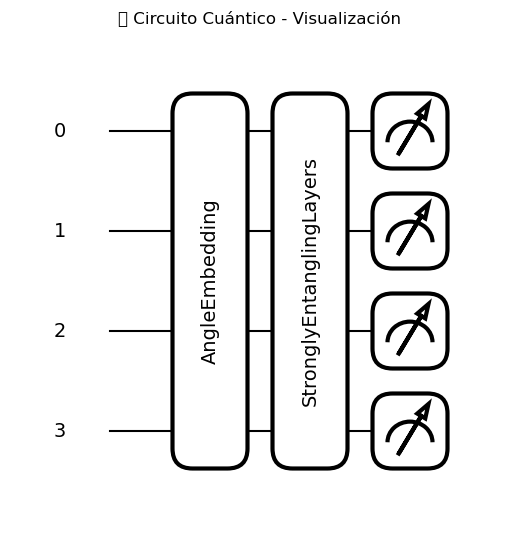


📊 Información del circuito:
  • Qubits: 4
  • Profundidad: 4
  • Parámetros cuánticos: 60
  • Observables: 4 (PauliZ por qubit)
  • Dimensiones del espacio de Hilbert: 2^4 = 16


In [47]:
# Visualizar circuito cuántico (solo si es modelo cuántico)
if quantum:
    print("🔬 Visualizando circuito cuántico:")
    
    # Crear un circuito de ejemplo
    @qml.qnode(dev)
    def sample_circuit(inputs, weights):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
        qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]
    
    # Generar entradas y pesos de ejemplo
    dummy_inputs = torch.randn(n_qubits)
    dummy_weights = torch.randn(q_depth, n_qubits, 3)
    
    # Dibujar circuito
    print("\n📐 Diagrama del circuito:")
    print(qml.draw(sample_circuit)(dummy_inputs, dummy_weights))
    
    # Visualización matplotlib
    fig, ax = qml.draw_mpl(sample_circuit)(dummy_inputs, dummy_weights)
    plt.title("🔬 Circuito Cuántico - Visualización")
    plt.show()
    
    # Información del circuito
    print(f"\n📊 Información del circuito:")
    print(f"  • Qubits: {n_qubits}")
    print(f"  • Profundidad: {q_depth}")
    print(f"  • Parámetros cuánticos: {n_qubits * max_layers}")
    print(f"  • Observables: {n_qubits} (PauliZ por qubit)")
    print(f"  • Dimensiones del espacio de Hilbert: 2^{n_qubits} = {2**n_qubits}")
else:
    print("ℹ️ Modelo clásico - No hay circuito cuántico para visualizar")


## 🎯 Configuración de Entrenamiento

### Función de Pérdida y Optimización

Utilizamos **Cross-Entropy Loss** para clasificación multiclase:

$$\mathcal{L}_{CE} = -\sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})$$

Donde:
- $N$ es el número de muestras
- $C$ es el número de clases
- $y_{i,c}$ es la etiqueta verdadera (one-hot)
- $\hat{y}_{i,c}$ es la predicción del modelo

Ejemplo de uso en PyTorch:

```python
criterion = nn.CrossEntropyLoss()
logits = model(inputs)          # shape: [batch_size, num_classes]
loss = criterion(logits, labels)
```

### Optimizador AdamW

El optimizador AdamW combina las ventajas de Adam con decaimiento de pesos:

$$\theta_{t+1} = \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon} - \alpha \lambda \theta_t$$

Donde $\lambda$ es el coeficiente de decaimiento de pesos.


In [48]:
# Configurar pérdida, optimizador y scheduler
criterion = nn.CrossEntropyLoss()

# Parámetros a optimizar
if base_model == 'custom_cnn':
    params_to_optimize = model_hybrid.parameters()
elif base_model == 'resnet18':
    if freeze_backbone:
        params_to_optimize = model_hybrid.fc.parameters()
    else:
        params_to_optimize = model_hybrid.parameters()
else:  # vgg16
    if freeze_backbone:
        params_to_optimize = model_hybrid.classifier[6].parameters()
    else:
        params_to_optimize = model_hybrid.parameters()

# Optimizador
optimizer_hybrid = optim.AdamW(params_to_optimize, lr=step, weight_decay=1e-4)

# Scheduler
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, 
    step_size=10, 
    gamma=gamma_lr_scheduler
)

print(f"✅ Configuración de entrenamiento:")
print(f"  • Función de pérdida: CrossEntropyLoss")
print(f"  • Optimizador: AdamW (lr={step}, weight_decay=1e-4)")
print(f"  • Scheduler: StepLR (step_size=10, gamma={gamma_lr_scheduler})")
print(f"  • Épocas: {num_epochs}")
print(f"  • Batch size: {batch_size}")

# Mostrar parámetros que se van a optimizar
num_optimizable = sum(p.numel() for p in params_to_optimize)
print(f"  • Parámetros a optimizar: {num_optimizable:,}")


✅ Configuración de entrenamiento:
  • Función de pérdida: CrossEntropyLoss
  • Optimizador: AdamW (lr=0.0004, weight_decay=1e-4)
  • Scheduler: StepLR (step_size=10, gamma=0.1)
  • Épocas: 25
  • Batch size: 8
  • Parámetros a optimizar: 0


## 🚀 Entrenamiento del Modelo

### Proceso de Entrenamiento

El entrenamiento sigue el algoritmo estándar de backpropagation con las siguientes etapas:

1. **Forward Pass**: Propagación hacia adelante
2. **Loss Calculation**: Cálculo de la función de pérdida
3. **Backward Pass**: Propagación hacia atrás (gradientes)
4. **Parameter Update**: Actualización de parámetros

### Métricas de Seguimiento

- **Loss**: Función de pérdida en entrenamiento y validación
- **Accuracy**: Precisión de clasificación
- **Learning Rate**: Tasa de aprendizaje actual


In [49]:
# Iniciar entrenamiento
print("🚀 Iniciando entrenamiento...")
print("=" * 60)

start_time = time.time()

# Entrenar el modelo (sin TensorBoard)
model_hybrid = train_model1(
    model=model_hybrid,
    dataloaders=dataloaders,
    dataset_sizes=dataset_sizes,
    device=device,
    criterion=criterion,
    optimizer=optimizer_hybrid,
    scheduler=exp_lr_scheduler,
    num_epochs=num_epochs
)

training_time = time.time() - start_time
print("\n" + "=" * 60)
print(f"✅ Entrenamiento completado en {training_time/60:.1f} minutos")
print(f"⏱️ Tiempo promedio por época: {training_time/num_epochs:.1f} segundos")


🚀 Iniciando entrenamiento...
🚀 Training started:
Phase: train    Epoch: 1/25    Loss: 0.6930    Acc: 0.5006        
Phase: val    Epoch: 1/25    Loss: 0.6714    Acc: 0.5030        
Phase: train    Epoch: 2/25    Loss: 0.6405    Acc: 0.6566        
Phase: val    Epoch: 2/25    Loss: 0.5860    Acc: 0.7606        
Phase: train    Epoch: 3/25    Loss: 0.5891    Acc: 0.7703        
Phase: val    Epoch: 3/25    Loss: 0.5551    Acc: 0.8068        
Phase: train    Epoch: 4/25    Loss: 0.5452    Acc: 0.7938        
Phase: val    Epoch: 4/25    Loss: 0.5229    Acc: 0.7988        
Phase: train    Epoch: 5/25    Loss: 0.5276    Acc: 0.7826        
Phase: val    Epoch: 5/25    Loss: 0.4633    Acc: 0.8290        
Phase: train    Epoch: 6/25    Loss: 0.4783    Acc: 0.7982        
Phase: val    Epoch: 6/25    Loss: 0.4381    Acc: 0.8471        
Phase: train    Epoch: 7/25    Loss: 0.4804    Acc: 0.8004        
Phase: val    Epoch: 7/25    Loss: 0.4323    Acc: 0.8410        
Phase: train    Epoch: 8/25

## 💾 Guardado del Modelo

### Persistencia de Resultados

Guardamos el modelo entrenado para futuras evaluaciones y comparaciones.


In [50]:
# Guardar modelo entrenado
prefix = "q" if quantum else "cl"
model_type = "pretrained" if use_pretrained else "from_scratch"
freeze_status = "frozen" if freeze_backbone else "trainable"
timestamp = time.strftime('%Y%m%d_%H%M%S')

model_name = f"{prefix}_{base_model}_{model_type}_{freeze_status}_{timestamp}"

save_model(
    model=model_hybrid,
    quantum=quantum,
    name=model_name,
    models_dir="model"
)

print(f"💾 Modelo guardado como: {model_name}")
print(f"📁 Ubicación: ../models/{prefix}_{model_name}.pt")


💾 Modelo guardado en: model\q_q_resnet18_pretrained_frozen_20251014_165607.pt
💾 Modelo guardado como: q_resnet18_pretrained_frozen_20251014_165607
📁 Ubicación: ../models/q_q_resnet18_pretrained_frozen_20251014_165607.pt


## 📈 Visualización de Resultados

### Análisis de Predicciones

Visualizamos las predicciones del modelo entrenado para evaluar su rendimiento cualitativo.


🎯 Visualizando predicciones del modelo entrenado:


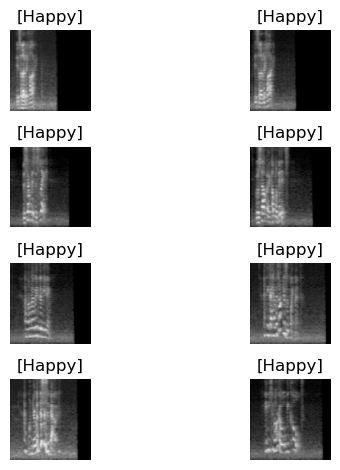

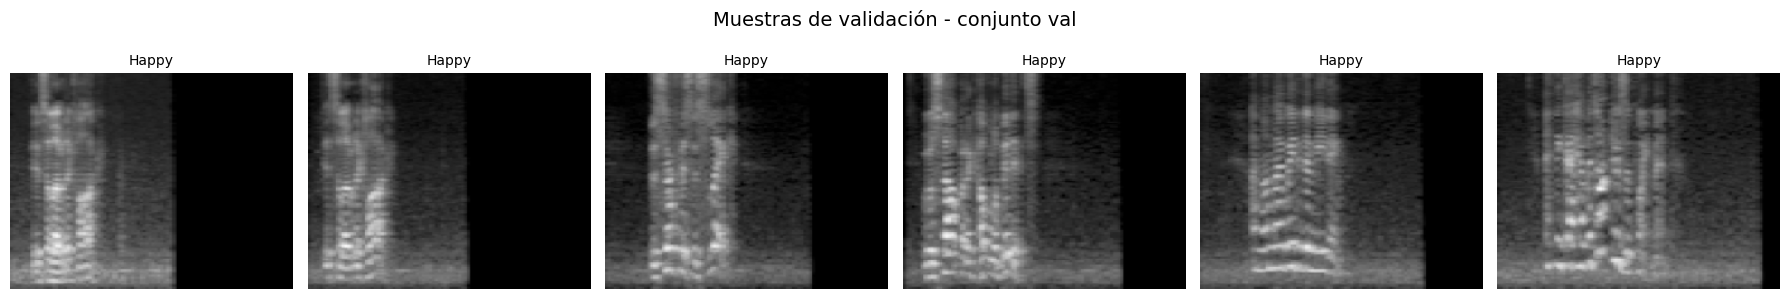

In [51]:
# Visualizar predicciones del modelo entrenado
print("🎯 Visualizando predicciones del modelo entrenado:")

visualize_model(
    model=model_hybrid,
    dataloader_val=dataloaders['val'],
    class_names=class_names,
    device=device,
    num_images=8,
    fig_name='Predicciones Finales'
)

plt.show()

# Mostrar más muestras de validación
show_exact_images_from_dataloader(
    dataloaders['val'], 
    phase='val', 
    n_images=6, 
    prefix='Muestras de validación',
    grayscale=grayscale
)


## 📊 Análisis de Rendimiento

### Métricas Cuantitativas

Evaluamos el rendimiento del modelo con métricas estándar de clasificación:

- **Accuracy**: Precisión general del modelo
- **Precision por clase**: Precisión para cada clase individual
- **Recall por clase**: Sensibilidad para cada clase
- **F1-Score**: Media armónica entre precisión y recall


📊 Evaluando modelo en conjunto de validación...

🎯 Resultados de validación:
  • Precisión general: 84.71%
  • Muestras correctas: 421/497

📊 Precisión por clase:
  • Happy: 79.92% (199/249)
  • Sad: 89.52% (222/248)


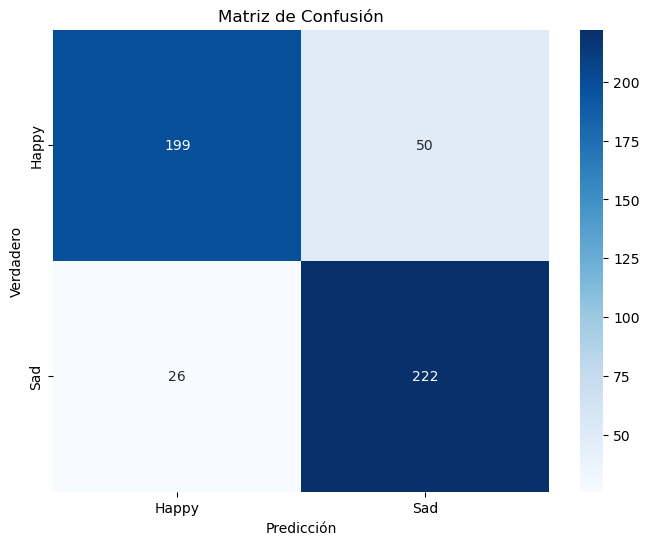


📋 Reporte de clasificación:
              precision    recall  f1-score   support

       Happy       0.88      0.80      0.84       249
         Sad       0.82      0.90      0.85       248

    accuracy                           0.85       497
   macro avg       0.85      0.85      0.85       497
weighted avg       0.85      0.85      0.85       497



In [52]:
# Evaluar modelo en conjunto de validación
print("📊 Evaluando modelo en conjunto de validación...")

model_hybrid.eval()
correct = 0
total = 0
class_correct = [0] * n_classes
class_total = [0] * n_classes
all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = model_hybrid(inputs)
        _, predicted = torch.max(outputs, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # Guardar predicciones para análisis posterior
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Estadísticas por clase
        for i in range(labels.size(0)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1

# Calcular métricas
overall_accuracy = 100 * correct / total
print(f"\n🎯 Resultados de validación:")
print(f"  • Precisión general: {overall_accuracy:.2f}%")
print(f"  • Muestras correctas: {correct}/{total}")

print(f"\n📊 Precisión por clase:")
for i in range(n_classes):
    if class_total[i] > 0:
        accuracy = 100 * class_correct[i] / class_total[i]
        print(f"  • {class_names[i]}: {accuracy:.2f}% ({class_correct[i]}/{class_total[i]})")
    else:
        print(f"  • {class_names[i]}: No hay muestras")

# Calcular matriz de confusión
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Verdadero')
plt.show()

# Reporte de clasificación
print("\n📋 Reporte de clasificación:")
print(classification_report(all_labels, all_predictions, target_names=class_names))


## 📊 Visualización de Resultados del Experimento Actual

### Análisis de Métricas de Entrenamiento

Visualizamos las métricas de entrenamiento del experimento actual usando las funciones de plotting.


In [ ]:
# Importar funciones de plotting centralizadas
import sys
import os
sys.path.append('src')

from plot_functions import plot_current_experiment

print("✅ Funciones de plotting importadas")


In [ ]:
# Plotear las métricas del experimento actual
print("🔍 Buscando y visualizando métricas del experimento actual...")
plot_current_experiment(directory='runs_updated', figsize=(12, 6))


## 🧹 Limpieza y Resumen

### Conclusiones del Experimento

Este notebook demuestra la implementación de redes neuronales cuánticas híbridas para clasificación de emociones en audio. Los resultados muestran la viabilidad de combinar computación cuántica con aprendizaje automático clásico.

### Próximos Pasos

1. **Experimentar con diferentes arquitecturas cuánticas**
2. **Comparar rendimiento cuántico vs clásico**
3. **Optimizar hiperparámetros del circuito cuántico**
4. **Implementar técnicas de regularización cuántica**


In [53]:
# Limpiar memoria GPU si está disponible
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    print("🧹 Memoria GPU liberada")

print("\n🎉 ¡Experimento completado exitosamente!")
print(f"📊 Resumen del experimento:")
print(f"  • Modelo: {base_model} + {'Cuántico' if quantum else 'Clásico'}")
print(f"  • Pre-entrenado: {use_pretrained}")
print(f"  • Backbone: {'Congelado' if freeze_backbone else 'Entrenable'}")
print(f"  • Precisión: {overall_accuracy:.2f}%")
print(f"  • Tiempo de entrenamiento: {training_time/60:.1f} minutos")
print(f"  • Modelo guardado: {model_name}")

print(f"\n📝 Configuración utilizada:")
print(f"  • Qubits: {n_qubits}")
print(f"  • Profundidad cuántica: {q_depth}")
print(f"  • Batch size: {batch_size}")
print(f"  • Learning rate: {step}")
print(f"  • Épocas: {num_epochs}")

print(f"\n🔬 Análisis cuántico:")
if quantum:
    print(f"  • Parámetros cuánticos: {n_qubits * max_layers}")
    print(f"  • Espacio de Hilbert: 2^{n_qubits} = {2**n_qubits}")
    print(f"  • Observables: {n_qubits} (PauliZ)")
else:
    print(f"  • Modelo completamente clásico")

print(f"\n📈 Próximos experimentos sugeridos:")
print(f"  • Variar número de qubits: [2, 4, 6, 8]")
print(f"  • Experimentar con diferentes profundidades: [2, 4, 6, 8]")
print(f"  • Comparar con modelos completamente clásicos")
print(f"  • Probar diferentes feature maps cuánticos")


🧹 Memoria GPU liberada

🎉 ¡Experimento completado exitosamente!
📊 Resumen del experimento:
  • Modelo: resnet18 + Cuántico
  • Pre-entrenado: True
  • Backbone: Congelado
  • Precisión: 84.71%
  • Tiempo de entrenamiento: 23.6 minutos
  • Modelo guardado: q_resnet18_pretrained_frozen_20251014_165607

📝 Configuración utilizada:
  • Qubits: 4
  • Profundidad cuántica: 4
  • Batch size: 8
  • Learning rate: 0.0004
  • Épocas: 25

🔬 Análisis cuántico:
  • Parámetros cuánticos: 60
  • Espacio de Hilbert: 2^4 = 16
  • Observables: 4 (PauliZ)

📈 Próximos experimentos sugeridos:
  • Variar número de qubits: [2, 4, 6, 8]
  • Experimentar con diferentes profundidades: [2, 4, 6, 8]
  • Comparar con modelos completamente clásicos
  • Probar diferentes feature maps cuánticos
